#Первоначальные действия

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Переход в рабочую директорию
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ASZI')  # Укажите путь к вашей рабочей директории


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

# Установка необходимых библиотек
!pip install torch torchvision matplotlib

# Импорты
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets




In [3]:
#Подготовка данных (MNIST)
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))


Training data: 50000 Validation data: 10000 Test data: 10000


In [4]:
#Настройка графического ускорителя
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

print(f"Using device: {device}")


Using device: cuda


#Создание нейронной сети

In [5]:
#Создание нейронной сети
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

model = Net().to(device)


#функции потерь и функции обучения

In [6]:
#Настройка оптимизатора и функции потерь
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)



#Обучение модели

Определение функции обучения

In [7]:
from torch.cuda.amp import autocast, GradScaler

def fit(model, device, train_loader, val_loader, epochs):
    data_loader = {'train': train_loader, 'val': val_loader}
    train_loss, val_loss = [], []

    # Использование GradScaler для управления градиентами
    scaler = GradScaler()

    print("Fitting the model...")
    for epoch in range(epochs):
        loss_per_epoch, val_loss_per_epoch = 0, 0
        for phase in ('train', 'val'):
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for data in data_loader[phase]:
                inputs, labels = data[0].to(device), data[1].to(device)

                # Использование автоматической смешанной точности
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    # Обратное распространение ошибки с использованием AMP
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    loss_per_epoch += loss.item()
                else:
                    val_loss_per_epoch += loss.item()

        # Обновление learning rate
        scheduler.step(val_loss_per_epoch / len(val_loader))

        print(f"Epoch {epoch + 1}: Train Loss = {loss_per_epoch / len(train_loader):.4f}, Val Loss = {val_loss_per_epoch / len(val_loader):.4f}")
        train_loss.append(loss_per_epoch / len(train_loader))
        val_loss.append(val_loss_per_epoch / len(val_loader))

    return train_loss, val_loss



In [8]:
#Обучение модели
epochs = 10
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

<ipython-input-7-18ddce9a96af>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-7-18ddce9a96af>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Train Loss = 0.2764, Val Loss = 0.0818
Epoch 2: Train Loss = 0.1057, Val Loss = 0.0650
Epoch 3: Train Loss = 0.0820, Val Loss = 0.0532
Epoch 4: Train Loss = 0.0709, Val Loss = 0.0548
Epoch 5: Train Loss = 0.0655, Val Loss = 0.0597
Epoch 6: Train Loss = 0.0604, Val Loss = 0.0548
Epoch 7: Train Loss = 0.0576, Val Loss = 0.0578
Epoch 8: Train Loss = 0.0442, Val Loss = 0.0537
Epoch 9: Train Loss = 0.0426, Val Loss = 0.0517
Epoch 10: Train Loss = 0.0391, Val Loss = 0.0519


#Построение графиков потерь

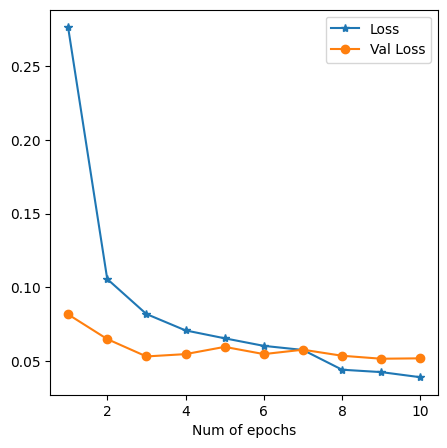

In [9]:
#Построение графиков потерь
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()


#Реализация атак (FGSM, I-FGSM, MI-FGSM)

In [10]:
#Реализация атак (FGSM, I-FGSM, MI-FGSM)
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

#Создание функции проверки

In [11]:
#Создание функции проверки
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples


#Тестирование с использованием функции проверки

Epsilon: 0	Test Accuracy = 9889 / 10000 = 0.9889
Epsilon: 0.007	Test Accuracy = 9853 / 10000 = 0.9853
Epsilon: 0.01	Test Accuracy = 9840 / 10000 = 0.984
Epsilon: 0.02	Test Accuracy = 9787 / 10000 = 0.9787
Epsilon: 0.03	Test Accuracy = 9707 / 10000 = 0.9707
Epsilon: 0.05	Test Accuracy = 9482 / 10000 = 0.9482
Epsilon: 0.1	Test Accuracy = 8337 / 10000 = 0.8337
Epsilon: 0.2	Test Accuracy = 4401 / 10000 = 0.4401
Epsilon: 0.3	Test Accuracy = 1443 / 10000 = 0.1443


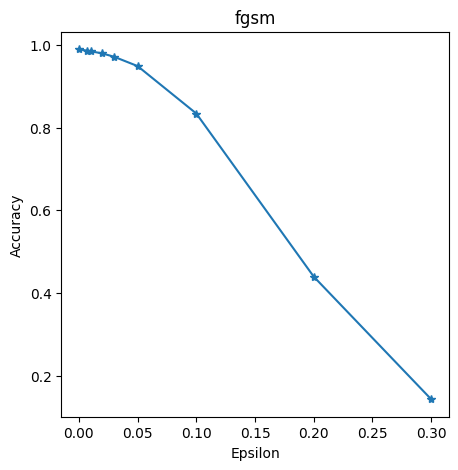

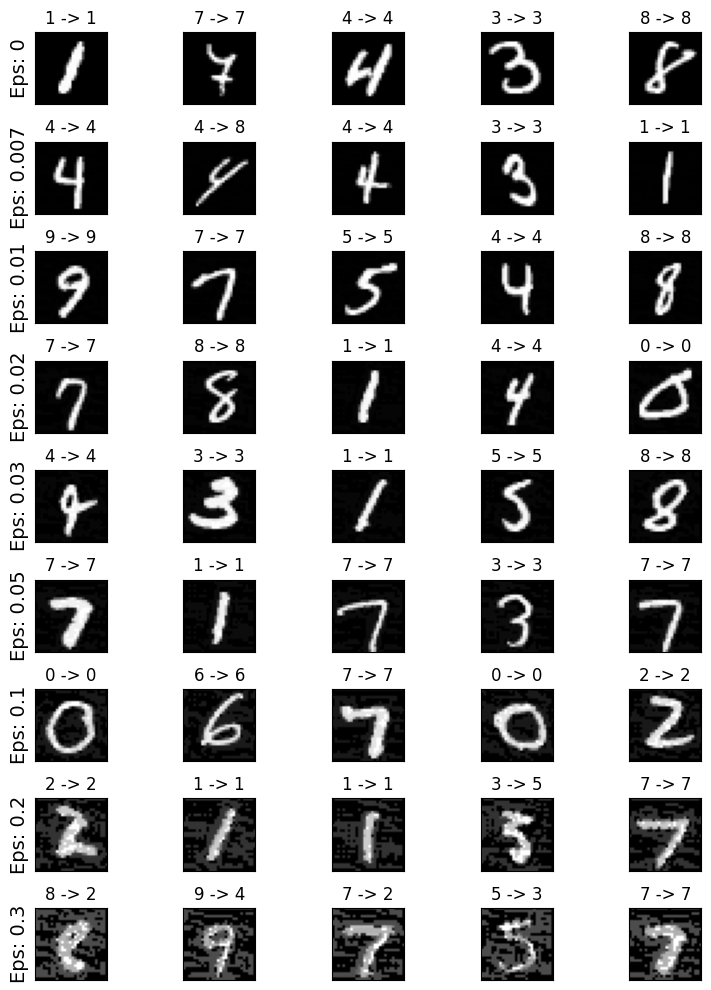

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epsilon: 0	Test Accuracy = 9889 / 10000 = 0.9889
Epsilon: 0.007	Test Accuracy = 9853 / 10000 = 0.9853
Epsilon: 0.01	Test Accuracy = 9840 / 10000 = 0.984
Epsilon: 0.02	Test Accuracy = 9787 / 10000 = 0.9787
Epsilon: 0.03	Test Accuracy = 9707 / 10000 = 0.9707
Epsilon: 0.05	Test Accuracy = 9482 / 10000 = 0.9482
Epsilon: 0.1	Test Accuracy = 8337 / 10000 = 0.8337
Epsilon: 0.2	Test Accuracy = 4401 / 10000 = 0.4401
Epsilon: 0.3	Test Accuracy = 1443 / 10000 = 0.1443


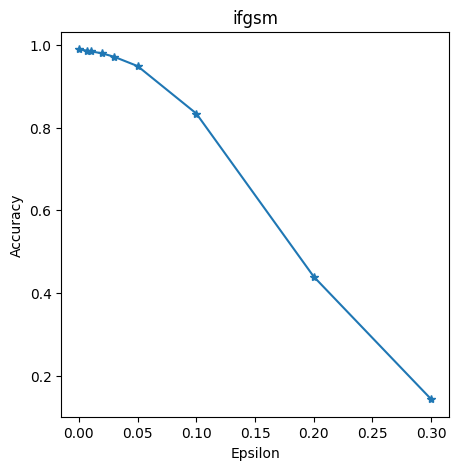

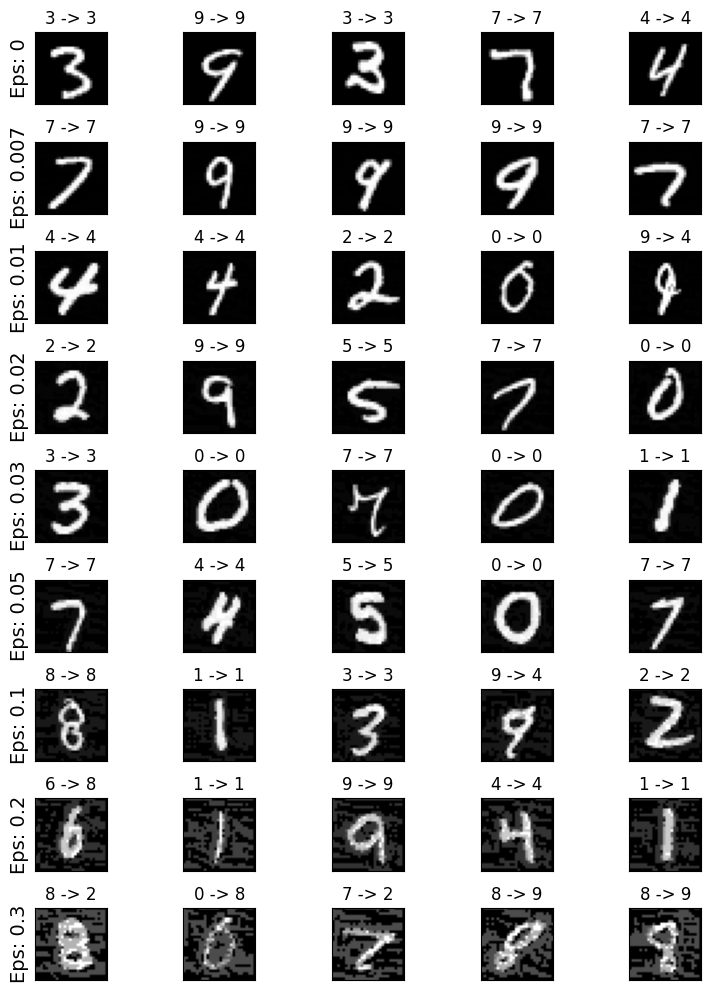

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epsilon: 0	Test Accuracy = 9889 / 10000 = 0.9889
Epsilon: 0.007	Test Accuracy = 9856 / 10000 = 0.9856
Epsilon: 0.01	Test Accuracy = 9843 / 10000 = 0.9843
Epsilon: 0.02	Test Accuracy = 9801 / 10000 = 0.9801
Epsilon: 0.03	Test Accuracy = 9733 / 10000 = 0.9733
Epsilon: 0.05	Test Accuracy = 9544 / 10000 = 0.9544
Epsilon: 0.1	Test Accuracy = 8633 / 10000 = 0.8633
Epsilon: 0.2	Test Accuracy = 5228 / 10000 = 0.5228
Epsilon: 0.3	Test Accuracy = 2004 / 10000 = 0.2004


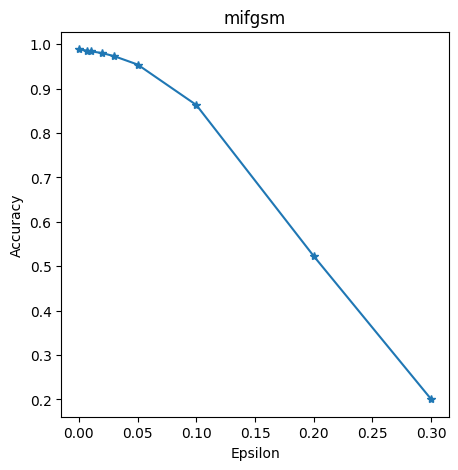

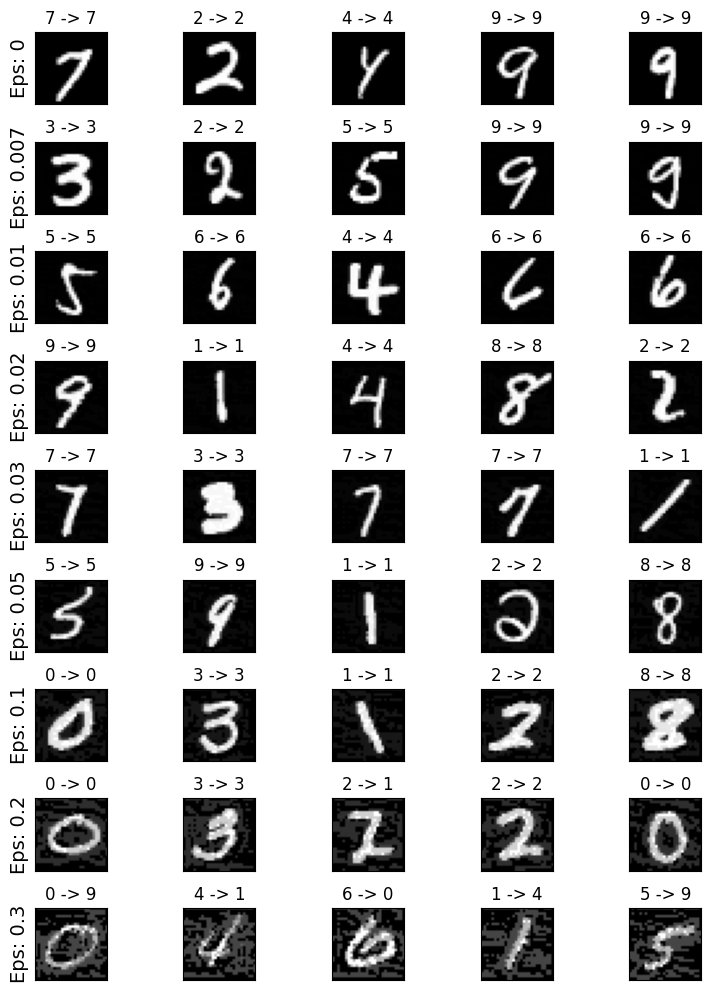

In [12]:
#графики успешности атак(Accuracy/эпсилон) и примеры выполненных атак в зависимости от степени возмущения epsilon
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()


#Создание двух классов нейронных сетей (НС)

In [13]:
#Реализация 2 класса НС
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

#Переопределение функции обучения и тестирования

In [14]:
#Переопределённая функции обучения и тестирования
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss
  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples



#Создание функции защиты методом дистилляции

In [15]:
#Реализация функции дистилляции
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()



#Результаты оценки защищенных сетей

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.5508121758727093 Val_Loss: 0.00044290595054626464
Epoch: 2 Loss: 0.3206377892035184 Val_Loss: 8.617536220990588e-05
Epoch: 3 Loss: 0.22752695838836134 Val_Loss: 1.1741677997633816e-06
Epoch: 4 Loss: 0.18047597454834624 Val_Loss: 1.0145256648320355e-05
Epoch: 5 Loss: 0.14502569653038458 Val_Loss: 6.741402318084511e-08
Epoch: 6 Loss: 0.12632294493522475 Val_Loss: 2.7151070392574183e-05
Epoch: 7 Loss: 0.11404786854418919 Val_Loss: 3.0087194172665476e-07
Epoch: 8 Loss: 0.10475640796827472 Val_Loss: 5.9352663898607715e-06
Epoch: 9 Loss: 0.0984002785290794 Val_Loss: 6.079655122448457e-10
Epoch: 10 Loss: 0.0937493772845457 Val_Loss: 6.8066326548432696e-09


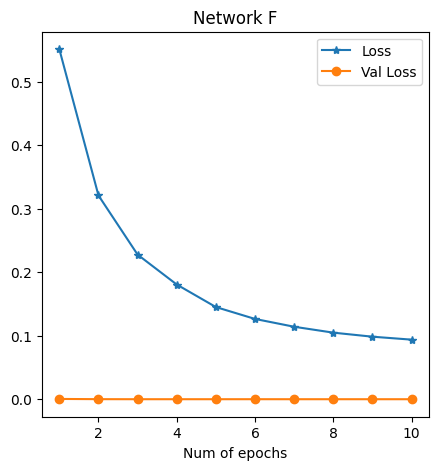

Fitting the model...
Epoch: 1 Loss: 0.7520156657736673 Val_Loss: 0.00022135303887189367
Epoch: 2 Loss: 0.5085040583868289 Val_Loss: 0.00011520260209217668
Epoch: 3 Loss: 0.46723676902691186 Val_Loss: 2.6917637791484593e-06
Epoch: 4 Loss: 0.43499250286884317 Val_Loss: 6.690507780876942e-06
Epoch: 5 Loss: 0.4044232495941421 Val_Loss: 4.485113635892049e-05
Epoch: 6 Loss: 0.36972634689092954 Val_Loss: 0.00011601418852806091
Epoch: 7 Loss: 0.3177667663849116 Val_Loss: 1.01826447295025e-05
Epoch: 8 Loss: 0.2795061749806426 Val_Loss: 2.9643097694497556e-05
Epoch: 9 Loss: 0.2728263147110879 Val_Loss: 4.692818588227965e-06
Epoch: 10 Loss: 0.26653439137086316 Val_Loss: 0.00018344275201670826


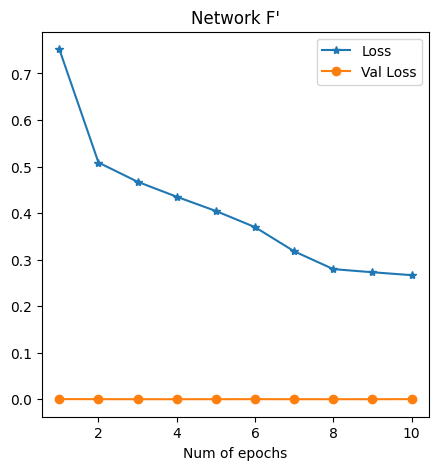

Epsilon: 0	Test Accuracy = 8797 / 10000 = 0.8797
Epsilon: 0.007	Test Accuracy = 8788 / 10000 = 0.8788
Epsilon: 0.01	Test Accuracy = 8725 / 10000 = 0.8725
Epsilon: 0.02	Test Accuracy = 8660 / 10000 = 0.866
Epsilon: 0.03	Test Accuracy = 8642 / 10000 = 0.8642
Epsilon: 0.05	Test Accuracy = 8466 / 10000 = 0.8466
Epsilon: 0.1	Test Accuracy = 7919 / 10000 = 0.7919
Epsilon: 0.2	Test Accuracy = 6057 / 10000 = 0.6057
Epsilon: 0.3	Test Accuracy = 3393 / 10000 = 0.3393
Epsilon: 0	Test Accuracy = 8818 / 10000 = 0.8818
Epsilon: 0.007	Test Accuracy = 8737 / 10000 = 0.8737
Epsilon: 0.01	Test Accuracy = 8719 / 10000 = 0.8719
Epsilon: 0.02	Test Accuracy = 8669 / 10000 = 0.8669
Epsilon: 0.03	Test Accuracy = 8586 / 10000 = 0.8586
Epsilon: 0.05	Test Accuracy = 8450 / 10000 = 0.845
Epsilon: 0.1	Test Accuracy = 7929 / 10000 = 0.7929
Epsilon: 0.2	Test Accuracy = 6117 / 10000 = 0.6117
Epsilon: 0.3	Test Accuracy = 3363 / 10000 = 0.3363
Epsilon: 0	Test Accuracy = 8812 / 10000 = 0.8812
Epsilon: 0.007	Test Accurac

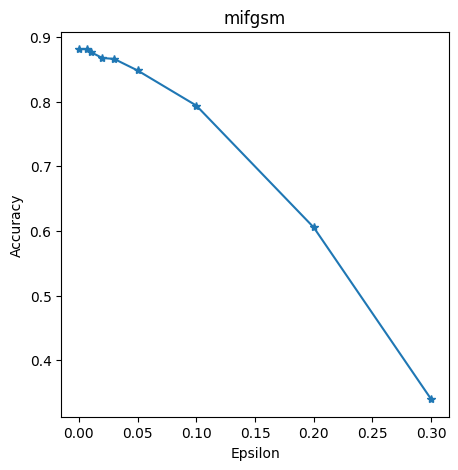

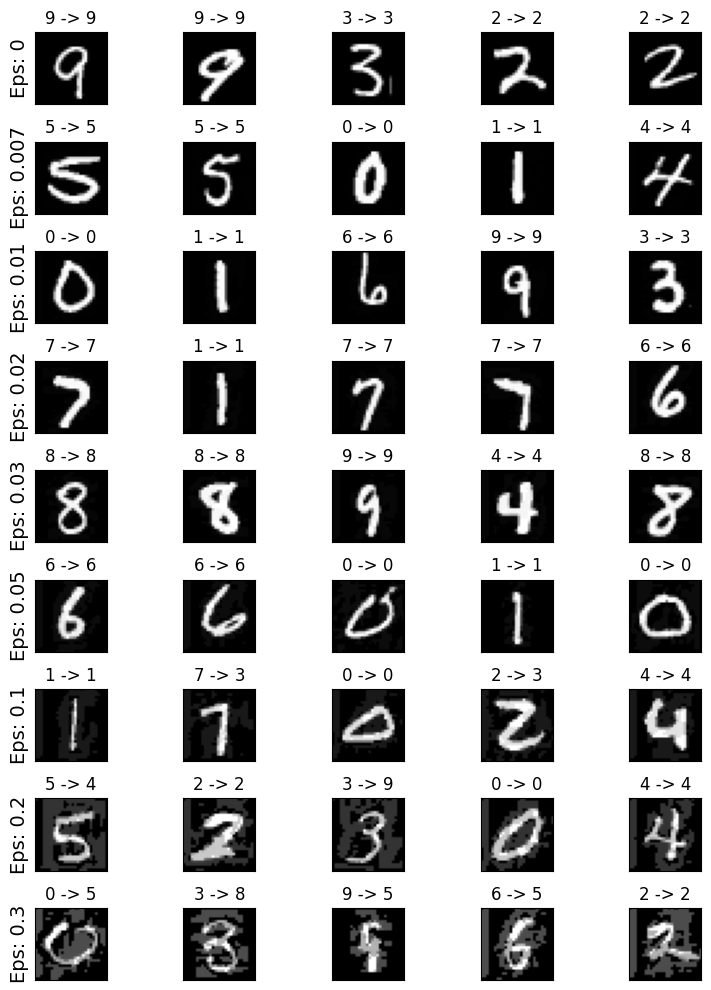

In [16]:
#Pезультаты оценки защищенных сетей
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)




#Выводы
Таким образом, в результате выполнения работы удалось выяснить, что применение защитной дистилляции обеспечивает безопасность и надежность нейронных сетей (НС). Защитная дистилляция демонстрирует потенциал снижения уязвимости моделей к различным видам атак. Однако стойкость предложенного способа защиты следует тщательно оценивать и тестировать в разнообразных условиях, учитывая возможные эволюции методов атак. Благодаря защитной дистилляции улучшился общий результат работы.